# Getting started with PyMC3

## PyMC3 primer - posterior

In [5]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [6]:
az.style.use('arviz-darkgrid')

In [7]:
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

In [8]:
# create container for the model
with pm.Model() as our_first_model: 
    # spec for prior dist
    θ = pm.Beta('θ', alpha=1., beta=1.) 
    # spec for likelihood dist
    y = pm.Bernoulli('y', p=θ, observed=data)
    # inferencing samples from posterior
    trace = pm.sample(1000, random_seed=123) 

# framework automatically assigns NUTS sampler and is used for 
# sampling results. it uses 4 chains, 1000 samples for each chain

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/2590444788.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


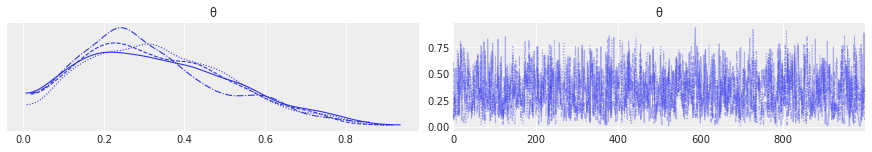

In [21]:
with our_first_model: 
    az.plot_trace(trace)
    plt.savefig('./images/01_plottrace_sample.png', dpi=300)
# Left plot - KDE - Kernel Density Estimation plot
# Right plot - individual sampled values during sampling

<img src='./images/01_plottrace_sample.png'>

In [24]:
with our_first_model: 
    display(az.summary(trace))

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
θ  0.332  0.18   0.016     0.65      0.005    0.003    1418.0    1928.0    1.0

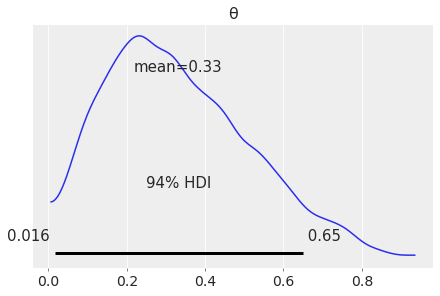

In [23]:
with our_first_model: 
    az.plot_posterior(trace)
    plt.savefig('./images/01_plotposterior_sample.png', dpi=300)

<img src='./images/01_plotposterior_sample.png'>

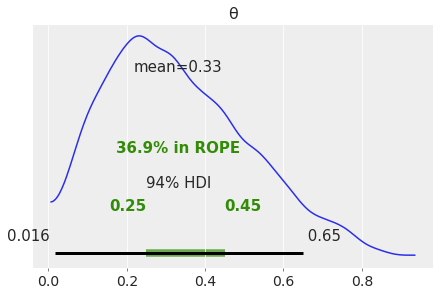

In [26]:
with our_first_model: 
    az.plot_posterior(trace, rope=[0.25, .45])
    plt.savefig('./images/01_plotposterior_withrope_sample.png', dpi=300)
    # used for making inference within a margin
    # ROPE - Region of Practical Equivalence
    #   - chance of observing exactly
    # HDI - Highest Density Interval

<img src='./images/01_plotposterior_withrope_sample.png'>

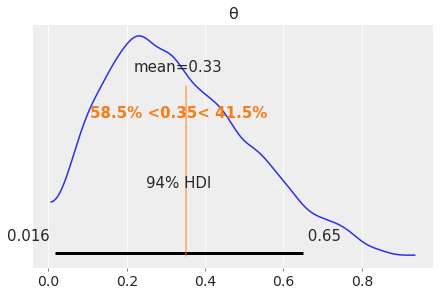

In [29]:
with our_first_model: 
    az.plot_posterior(trace, ref_val=0.35)
    plt.savefig('./images/01_plotposterior_ref_discrete.png', dpi=300)

<img src='./images/01_plotposterior_ref_discrete.png'>

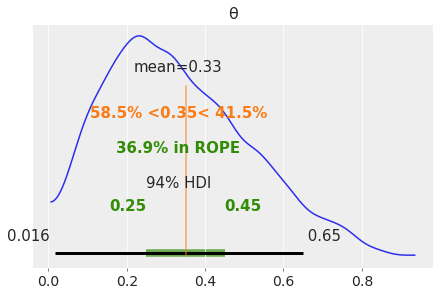

In [33]:
with our_first_model: 
    az.plot_posterior(trace, rope=[0.25, .45], ref_val=0.35)
    plt.savefig('./images/01_plotposterior_rope_ref.png', dpi=300)
    
# 3 scenarios:
# - ROPE does not overlap with HDI - coin is not fair
# - ROPE contains entire HPI - coin is fair
# - ROPE partially overlaps with HPI - coin is fair or unfair

<img src='./images/01_plotposterior_rope_ref.png'>

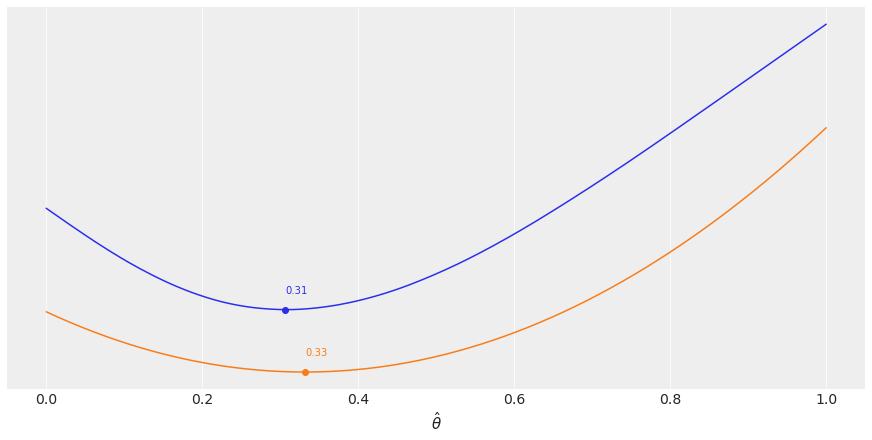

In [50]:
# setting the plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
# Median of posterior - absolute loss
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid] 
# Mean of posterior - quadratic loss
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
plt.xlabel(r'$\hat \theta$');
plt.savefig('./images/01_diff_loss_func.png', dpi=300)

# Different loss functions have different point-estimates

<img src='./images/01_diff_loss_func.png'>

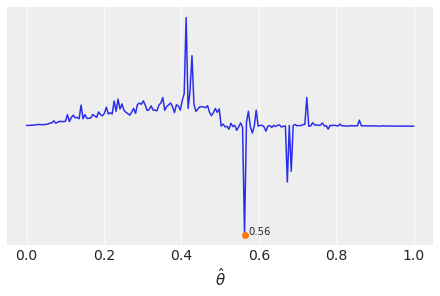

In [51]:
# How to choose the loss function
# asymmetric loss function below

lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$');
plt.savefig('./images/01_choose_loss_func.png', dpi=300)

<img src='./images/01_choose_loss_func.png'>

## Gaussian Inferences

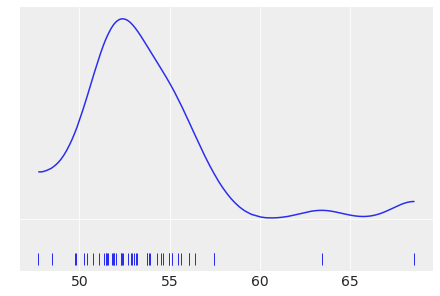

In [52]:
data = np.loadtxt('./data/chemical_shifts.csv')
az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)
plt.savefig('./images/02_plotposterior_rope_ref.png', dpi=300);

<img src="./images/02_plotposterior_rope_ref.png">

$$\mu \sim U(l,h)\text{ - Uniform distribution}$$
$$\sigma \sim N(0,\sigma_{\sigma})\text{ - Half Normal distribution}$$
$$y \sim N(\mu,\sigma)\text{ - Normal distribution}$$

In [66]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3531102442.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


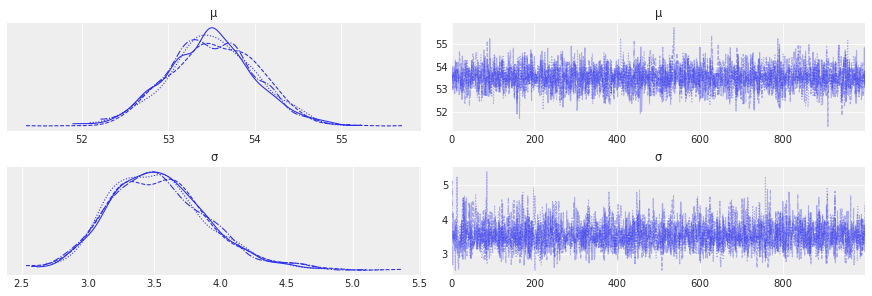

In [54]:
with model_g: 
    az.plot_trace(trace_g) # SD = 10
    plt.savefig('./images/02_plottrace_sample.png', dpi=300)

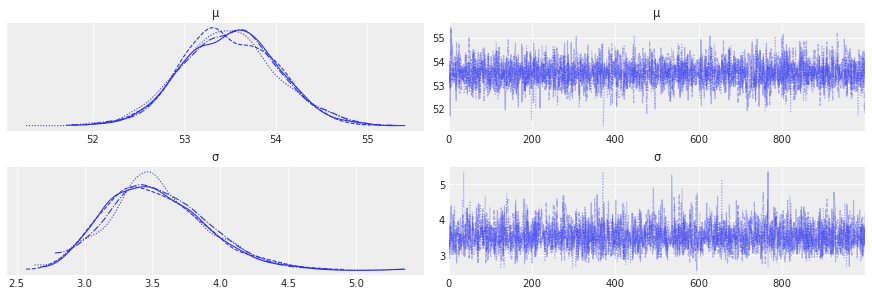

In [67]:
with model_g: 
    az.plot_trace(trace_g) # SD = 5
    plt.savefig('./images/02_plottrace_sample.png', dpi=300)

<img src='./images/02_plottrace_sample.png'>

In [58]:
with model_g:
    display(az.summary(trace_g)) # SD = 10

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.508  0.514  52.561   54.483      0.009    0.006    3562.0    2801.0   
σ   3.538  0.379   2.845    4.225      0.006    0.004    3591.0    2866.0   

   r_hat  
μ    1.0  
σ    1.0

In [68]:
with model_g:
    display(az.summary(trace_g)) # SD = 5

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.494  0.522  52.558   54.521      0.009    0.006    3273.0    2232.0   
σ   3.535  0.370   2.863    4.209      0.007    0.005    3063.0    2530.0   

   r_hat  
μ    1.0  
σ    1.0

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


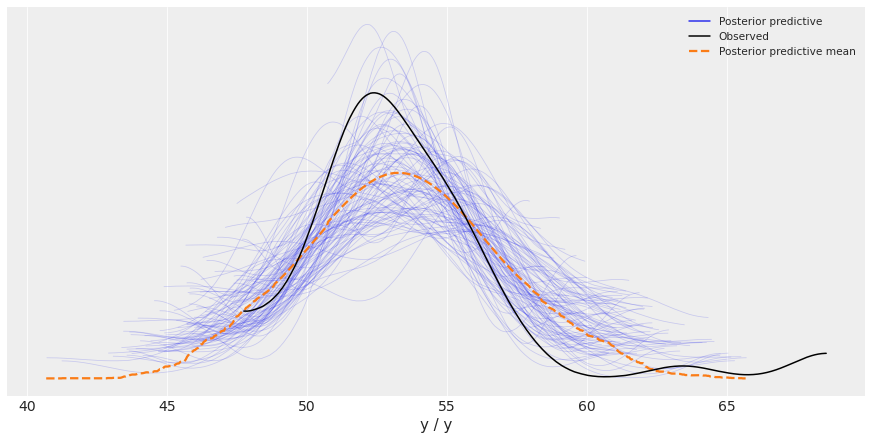

In [74]:
with model_g: # using SD=10
    y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)
    data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
#     ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
#     ax.legend(fontsize=15)
    
#     data = az.load_arviz_data("non_centered_eight")
    az.plot_ppc(data_ppc, data_pairs={"obs": "obs"}, figsize=(12, 6), textsize=14)

#     plt.show()
    plt.savefig('./images/02_plot_inferred_dist.png', dpi=300)

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


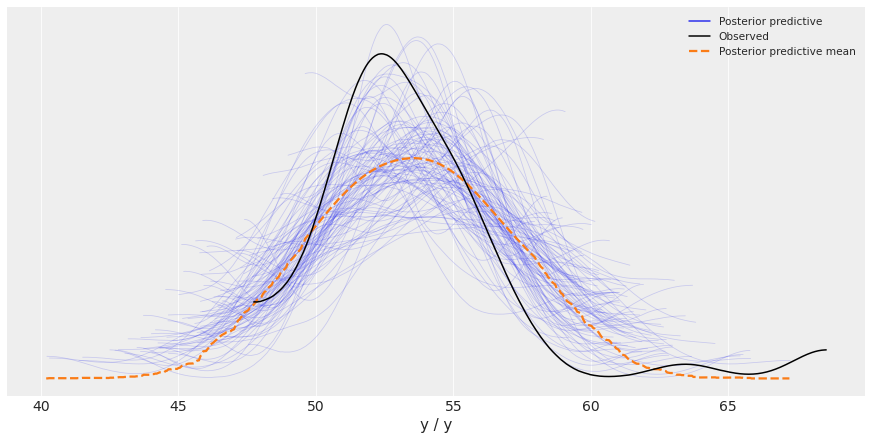

In [69]:
with model_g: # using SD=5
    y_pred_g = pm.sample_posterior_predictive(trace_g, 100, model_g)
    data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)
#     ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
#     ax.legend(fontsize=15)
    
#     data = az.load_arviz_data("non_centered_eight")
    az.plot_ppc(data_ppc, data_pairs={"obs": "obs"}, figsize=(12, 6), textsize=14)

    plt.show() # KDE
    # Semitransparent lines reflect the uncertainty about 
    # inferred distribution of the predicted data.

<img src='./images/02_plot_inferred_dist.png'>

It was assumed that model_g is normally distributed, but there are two data points on the right tail.
- Is it outlier? 
- Can it be eliminated by cleaning the data
- Should we make different priors and likelihood instead of cleaning the outlier data
  - replace the Gaussian distribution with Student's t-distribution
  - use Cauchy-Lorentz distribution with heavier tails 
    - In Cauchy distribution, 95% of the values are found between -12.7 and 12.7 
    - In Gaussian distribution, 1 SD occurs between -1.96 and 1.96
- Replace Gaussian likelihood with Student's t-distribution
  - Mean, scale, degrees of freedom(normality parameter $\nu$)
    - variance of Student's t-distribution is only defined for values of $\nu \gt 2$. 
    - the scale of Student's t-distribution is not the same as the standard deviation. 
    - For $\nu \le 2$, the distribution has no defined variance and hence no defined standard deviation. 
    - The scale and the standard deviation become closer and closer as  approaches infinity
    
Redefining model

$$\mu \sim U(l,h)\text{ - Uniform distribution}$$
$$\sigma \sim N(0,\sigma_{\sigma})\text{ - Half Normal distribution}$$
$$\nu \sim Exp(\lambda)$$
$$y \sim T(\mu,\sigma, \nu)\text{ - Student's T-distribution}$$


In [91]:
plt.figure(figsize=(12, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('./images/02_plot_tdist.png')
plt.close();


<img src='./images/02_plot_tdist.png'>

In [90]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
    az.plot_trace(trace_t)
    plt.savefig('./images/02_plot_tdist_trace.png')
    plt.close();

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/536442724.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8908202224494399, but should be close to 0.8. Try to increase the number of tuning steps.


<img src='./images/02_plot_tdist_trace.png'>

In [79]:
# Comparing the tracee summary of both the models
with model_t:
    display(az.summary(trace_t))
with model_g:
    display(az.summary(trace_g))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.006  0.393  52.275   53.708      0.008    0.006    2452.0    2389.0   
σ   2.199  0.413   1.492    2.995      0.009    0.007    1976.0    2038.0   
ν   4.799  4.790   1.176    9.818      0.141    0.100    1960.0    1614.0   

   r_hat  
μ    1.0  
σ    1.0  
ν    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.494  0.522  52.558   54.521      0.009    0.006    3273.0    2232.0   
σ   3.535  0.370   2.863    4.209      0.007    0.005    3063.0    2530.0   

   r_hat  
μ    1.0  
σ    1.0

In [92]:
with model_t: 
    y_ppc_t = pm.sample_posterior_predictive(trace_t, 100, model_t)
    y_pred_t = az.from_pymc3(trace=trace_t, posterior_predictive=y_ppc_t)
    az.plot_ppc(y_pred_t, data_pairs={"obs": "obs"}, figsize=(12, 6), textsize=14)
    plt.xlim(40, 70)
    plt.savefig('./images/02_plot_tdist_ppc.png') # KDE
    plt.close()
    # Semitransparent lines reflect the uncertainty about 
    # inferred distribution of the predicted data.

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


<img src='./images/02_plot_tdist_ppc.png'>

## Group Comparison

Tools used are to compare posterior distribution of means between groups is:
- A posterior plot with a reference value
- The Cohen's d

$$\frac{\mu_{2} - \mu_{1}}{\sqrt{\frac{\sigma_{2}^{2} + \sigma_{1}^{2}}{2}}}$$
- The probability of superiority


## tips dataset

In [93]:
tips = pd.read_csv('./data/tips.csv')
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

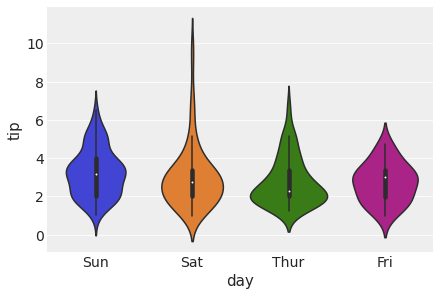

In [95]:
sns.violinplot(x='day', y='tip', data=tips);

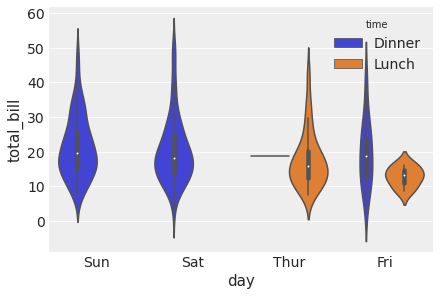

In [97]:
sns.violinplot(x ="day", y = "total_bill", hue = "time", data = tips);

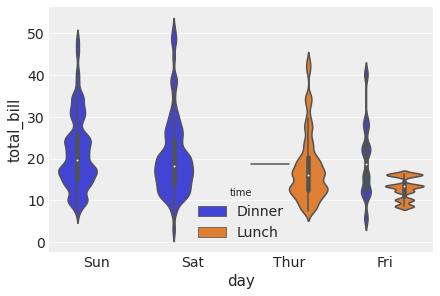

In [99]:
sns.violinplot(x ="day", y = "total_bill", hue = "time", bw = .15, data = tips);

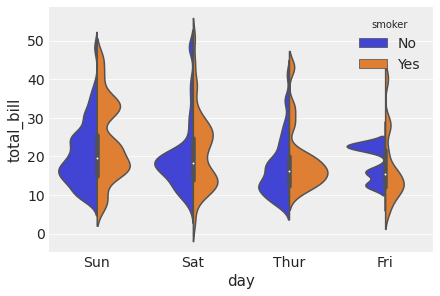

In [100]:
sns.violinplot(x ="day", y = "total_bill", hue = "smoker", bw = .25, split = True, data = tips);

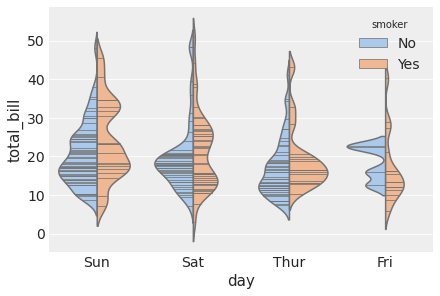

In [101]:
sns.violinplot(x="day", y="total_bill", hue="smoker", bw=.25, split=True, palette= "pastel", inner= "stick", data=tips);

In [102]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

In [107]:
tips

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/2042149275.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cg = pm.sample(5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.


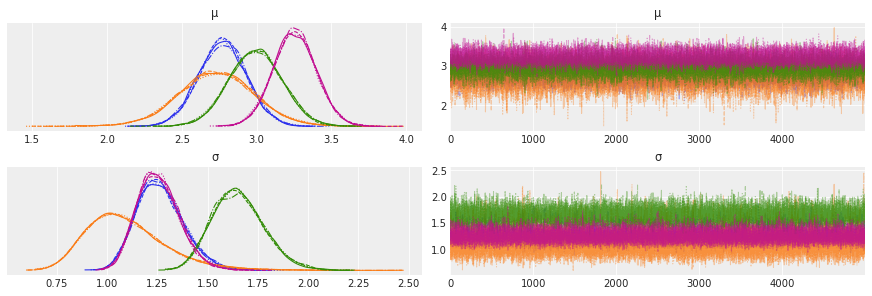

In [103]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
    az.plot_trace(trace_cg)

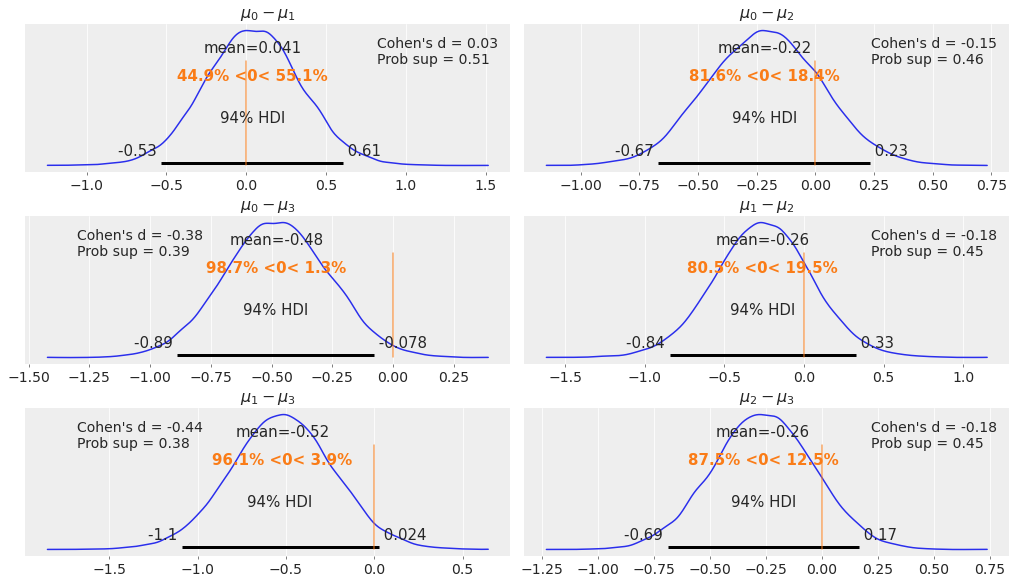

In [104]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:, i] - trace_cg['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:, i]**2 + trace_cg['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

## Hierarchical models

**Problem Statement**: Analyze the quality of water in a city by taking samples, dividing the city into neighborhoods. There are two options to analyze this data:
- Study each neighborhood as a separate entity
  - this will give a more detailed view
- Pool all the data together and estimate the water quality of the city as a single big group
  - more accurate estimation

Here both options are good. We can build a model which estimates the water quality of each neighborhood and also estimate the quality of water for the whole city. Such models are called **hierarchical model or multilevel model**

How to build hierarchical model?
- Instead of fixing the parameters of priors to constant numbers, we estimate them directly from the data by placing shared priors over them. 
  - These higher-level priors are often called **hyper-priors**, and their parameters **hyperparameters**
- Be careful: creating many levels can make the model difficult to understand and make inferences

In the example below, there are 3 groups, each one consisting of certain number of samples N_samples. G_samples contain the number of good quality samples per group.

In [108]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

The important features defined here are:
- There are 2 hyper-priors that influence the beta prior
- Instead of defining hyper-priors on parameters $\alpha$ and $\beta$, it is indirectly defined in terms of $\mu$, the mean of beta distribution and $\kappa$, the precision or concentration of beta distribution
  - the precision is inverse of standard deviation, the larger the $\kappa$, the more concentrated the beta distribution is
  

$$\mu \sim Beta(\alpha_{\mu},\beta_{\mu})\text{ - Beta distribution}$$
$$\kappa \sim Normal(0, \sigma)$$
$$\alpha = \mu * \kappa$$
$$\beta = (1-\mu) * \kappa$$
$$\theta_{i} \sim Beta(\alpha_{i},\beta_{i})\text{ - Beta distribution}$$
$$y_{i} \sim Bern(\theta_{i})\text{ - Bernoulli distribution}$$

Here the parameters $\alpha_{i},\beta_{i}$ are deterministic whereas the parameters $\mu, \theta, \kappa$ are stochastic in nature

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/1466362691.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_h = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


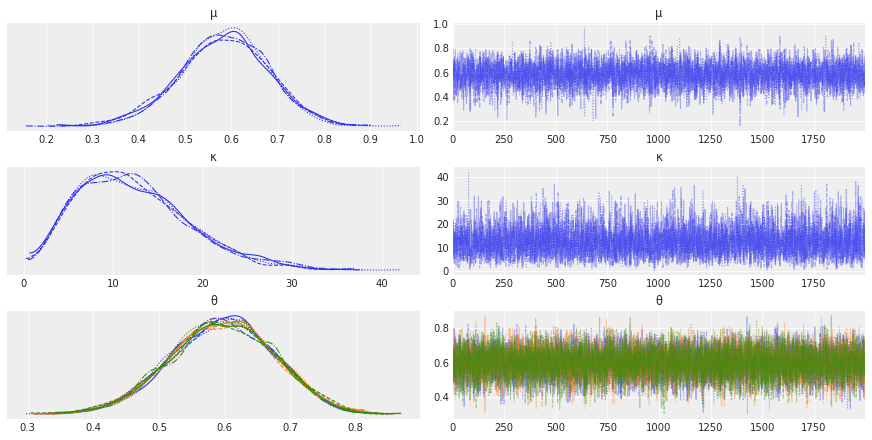

In [110]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h = pm.sample(2000)
    az.plot_trace(trace_h) 

In [111]:
with model_h:
    display(az.summary(trace_h))

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.584  0.096   0.404    0.766      0.001    0.001    5578.0    5666.0   
κ     12.315  6.230   2.264   24.055      0.087    0.061    4987.0    4660.0   
θ[0]   0.596  0.078   0.452    0.741      0.001    0.001    5769.0    5150.0   
θ[1]   0.596  0.080   0.456    0.753      0.001    0.001    5420.0    5073.0   
θ[2]   0.596  0.080   0.450    0.745      0.001    0.001    6508.0    5817.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

### Shrinkage
Repeating the same experiment by changing the good samples G_samples to 
- 1st run(above) - all elements of G_samples set to 18
- 2nd run - all elements of G_samples set to 3
- 3rd run - one element of G_samples set to 18 and other two set to 3

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/4055035227.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_h2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


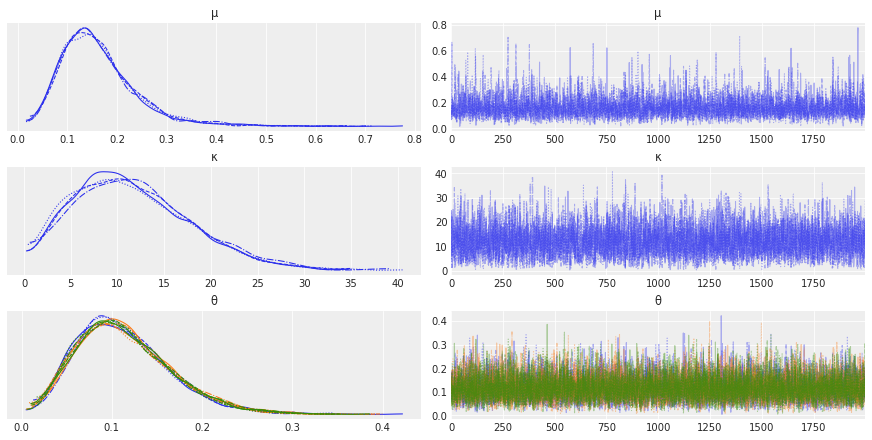

In [112]:
# 2nd run
N_samples = [30, 30, 30]
G_samples = [3, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
    
with pm.Model() as model_h2:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h2 = pm.sample(2000)
    az.plot_trace(trace_h2) 

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/1065814443.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_h3 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


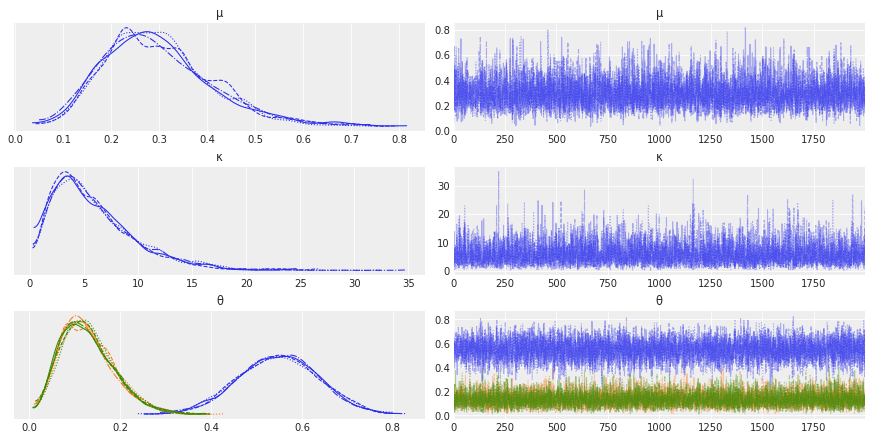

In [113]:
# 3rd run
N_samples = [30, 30, 30]
G_samples = [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
    
with pm.Model() as model_h3:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    trace_h3 = pm.sample(2000)
    az.plot_trace(trace_h3) 

In [114]:
# Analyzing the summary of all three models
with model_h:
    display(az.summary(trace_h))
with model_h2:
    display(az.summary(trace_h2))
with model_h3:
    display(az.summary(trace_h3))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.584  0.096   0.404    0.766      0.001    0.001    5578.0    5666.0   
κ     12.315  6.230   2.264   24.055      0.087    0.061    4987.0    4660.0   
θ[0]   0.596  0.078   0.452    0.741      0.001    0.001    5769.0    5150.0   
θ[1]   0.596  0.080   0.456    0.753      0.001    0.001    5420.0    5073.0   
θ[2]   0.596  0.080   0.450    0.745      0.001    0.001    6508.0    5817.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ      0.163  0.079   0.042    0.305      0.001    0.001    4469.0    4161.0   
κ     11.711  6.256   1.033   22.640      0.086    0.061    4585.0    3512.0   
θ[0]   0.113  0.051   0.031    0.212      0.001    0.000    5800.0    4794.0   
θ[1]   0.114  0.052   0.024    0.212      0.001    0.000    5185.0    4139.0   
θ[2]   0.113  0.052   0.025    0.210      0.001    0.000    5620.0    4205.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ     0.297  0.113   0.108    0.512      0.001    0.001    6150.0    4968.0   
κ     5.957  3.919   0.573   13.229      0.057    0.042    4735.0    4772.0   
θ[0]  0.548  0.087   0.388    0.715      0.001    0.001    6521.0    5663.0   
θ[1]  0.129  0.059   0.029    0.239      0.001    0.001    5597.0    3879.0   
θ[2]  0.129  0.059   0.026    0.234      0.001    0.001    5351.0    4211.0   

      r_hat  
μ       1.0  
κ       1.0  
θ[0]    1.0  
θ[1]    1.0  
θ[2]    1.0

Here the estimates are shrinking towards the common mean. This is the consequence of using hyper-priors, which is estimating the parameters of beta prior distribution from the dataset. Each group estimates, informs and shares information to other group of its result. This phenomenon is known as shrinkage. The learning over here is neither the consequence of all group data, nor does it come from one single group of data. It comes from both the set. 

The shrinkage contributes to more stable inferences about the data. This result in more robust or less responsive to data points if they are away from the mean. The model is hence, less responsive to extreme values in individual groups. The amount of shrinkage depends on the data, one single group with outliered or dissimilar data will have less of impact on the grouped data. The several similar groups will pull the estimation towards them than towards the estimation from the less similar group.



/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3850269264.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


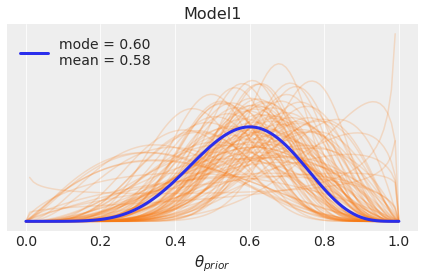

In [116]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h), size=100):
    u = trace_h['μ'][i]
    k = trace_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h['μ'].mean()
k_mean = trace_h['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.title('Model1')
plt.tight_layout()

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/819160916.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


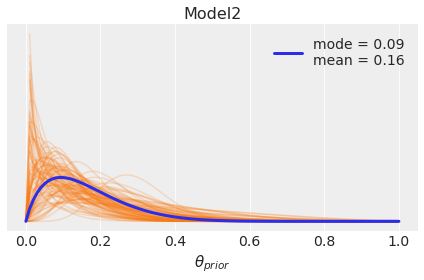

In [117]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h2), size=100):
    u = trace_h2['μ'][i]
    k = trace_h2['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h2['μ'].mean()
k_mean = trace_h2['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.title('Model2')
plt.tight_layout()

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/1874894004.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


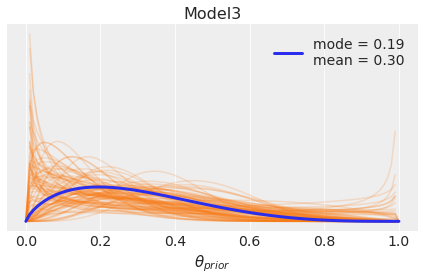

In [120]:
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h3), size=100):
    u = trace_h3['μ'][i]
    k = trace_h3['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = trace_h3['μ'].mean()
k_mean = trace_h3['κ'].mean()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.title('Model3')
plt.tight_layout()

## Compare groups

You will see four columns: 
- the first column is the protein id
- the second column is the name of the amino acid, a three-letter code
- the third column is the theoretical computed chemical shift values (using quantum chemical computations) and 
- the fourth column is the experimentally measured chemical shifts

**Problem Statement**: The motivation for this example is to compare the differences between the group and analyze how well the theoretical computations are reproducing the experimental measures

In [125]:
cs_data = pd.read_csv('./data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))
groups

19

In [122]:
display(cs_data)

ID   aa   theo    exp
0     1BM8  ILE  61.18  58.27
1     1BM8  TYR  56.95  56.18
2     1BM8  SER  56.35  56.84
3     1BM8  ALA  51.96  51.01
4     1BM8  ARG  56.54  54.64
...    ...  ...    ...    ...
1771  1KS9  LYS  55.79  57.51
1772  1KS9  ARG  58.91  59.02
1773  1KS9  LYS  59.49  58.92
1774  1KS9  GLU  59.48  58.36
1775  1KS9  SER  58.07  60.55

[1776 rows x 4 columns]

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/1210167883.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cs_nh = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


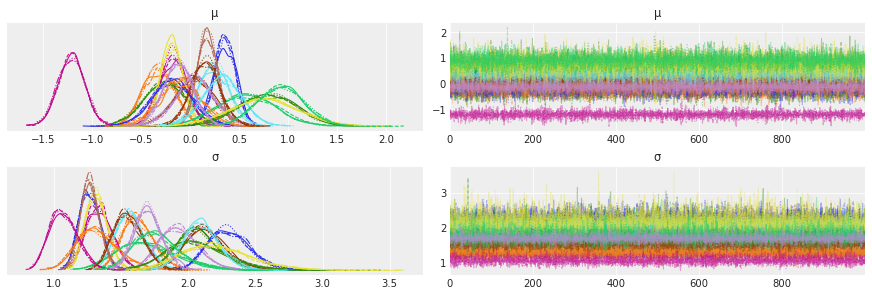

In [123]:
# To see the difference between a hierarchical and non-hierarchical model, lets build two models. 
# The first one is basically the same as the comparing_groups model

with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_nh = pm.sample(1000)
    az.plot_trace(trace_cs_nh) 

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/4263742250.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_cs_h = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


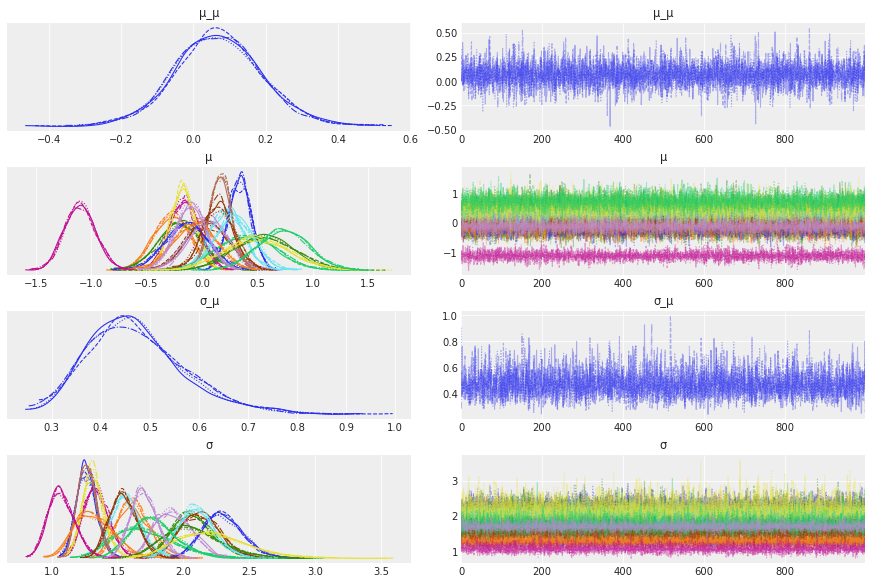

In [126]:
# Second build the hierarchical version of the model. 
# - Add two hyper-priors: one for the mean μ and one for the standard deviation σ. 
# - We are leaving σ without hyper-priors. 
# - This is just a model choice; I am deciding on a simpler model just for pedagogical purposes. 
# You may face a problem where this seems unacceptable and you may consider it necessary 
# to add a hyper-prior for ; feel free to do that:

with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    trace_cs_h = pm.sample(1000)
    az.plot_trace(trace_cs_h) 

ValueError: not enough values to unpack (expected 2, got 1)

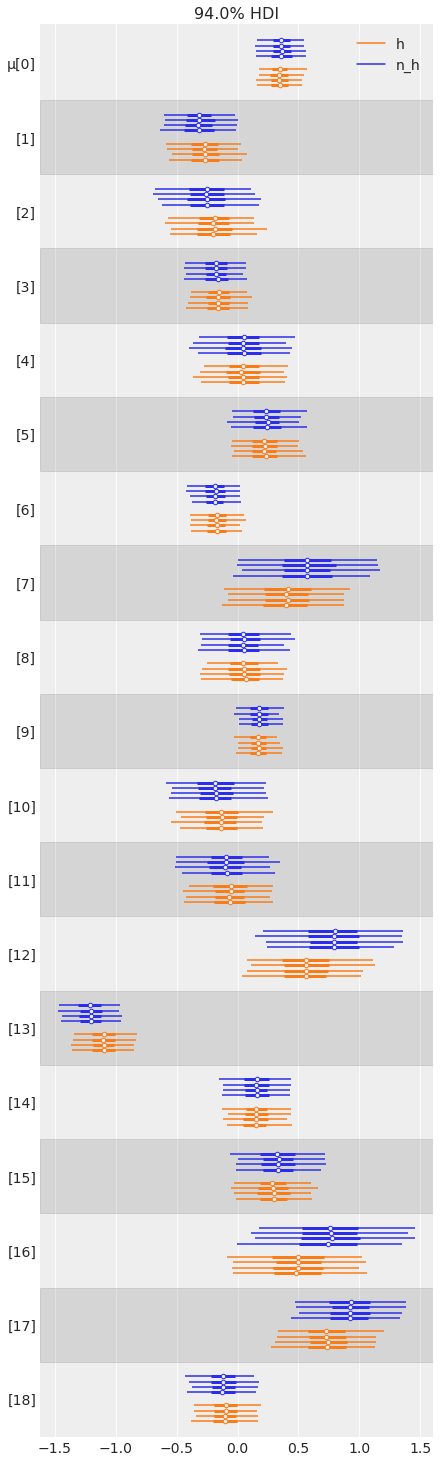

In [128]:
# To compare the results use ArviZ's plot_forest function. 
# - We can pass more than one model to this function. 
# - This is useful when we want to compare the values of parameters from different models 
  # such as with the present example. 
  # Notice that we are passing several arguments to plot_forest to get the plot that we want, 
  # like combined=True to merge results from all the chains. 
  # I invite you to explore the rest of the arguments:

with cs_h, cs_nh:
    _, axes = az.plot_forest([trace_cs_nh, trace_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
    y_lims = axes[0].get_ylim()
    axes[0].vlines(trace_cs_h['μ_μ'].mean(), *y_lims)

> Rewrite this below

The most relevant part of this plot is that the estimates from the hierarchical model are pulled toward the partially-pooled mean, or equivalently they are shrunken with respect to the un-pooled estimates. You will also notice that the effect is more notorious for those groups farther away from the mean (such as 13) and that the uncertainty is on par or smaller than that from the non-hierarchical model. The estimates are partially pooled because we have one estimate for each group, but estimates for individual groups restrict each other through the hyper-prior.

Therefore, we get an intermediate situation between having a single group, all chemical shifts together, and having 19 separated groups, one per amino acid.

## Modeling with Linear Regression
### Linear Regression
A linear regression model probabilistically can be expressed as:
$$y \sim N(\mu = \alpha + x\beta, \epsilon)$$

The prior distribution can be chosen as:

$$\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha})$$
$$\beta \sim N(\mu_{\beta}, \sigma_{\beta})$$
$$\epsilon \sim |N(0, \sigma_{\epsilon})|$$

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/460102601.py:18: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


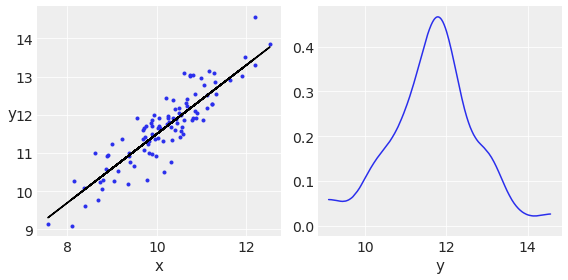

In [129]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3836700437.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_g = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


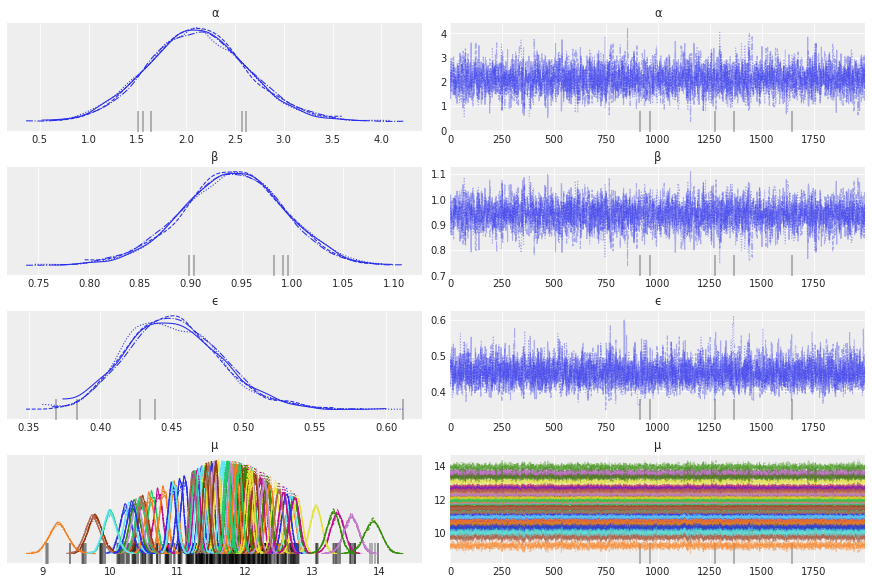

In [133]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=1000)
    az.plot_trace(trace_g) 

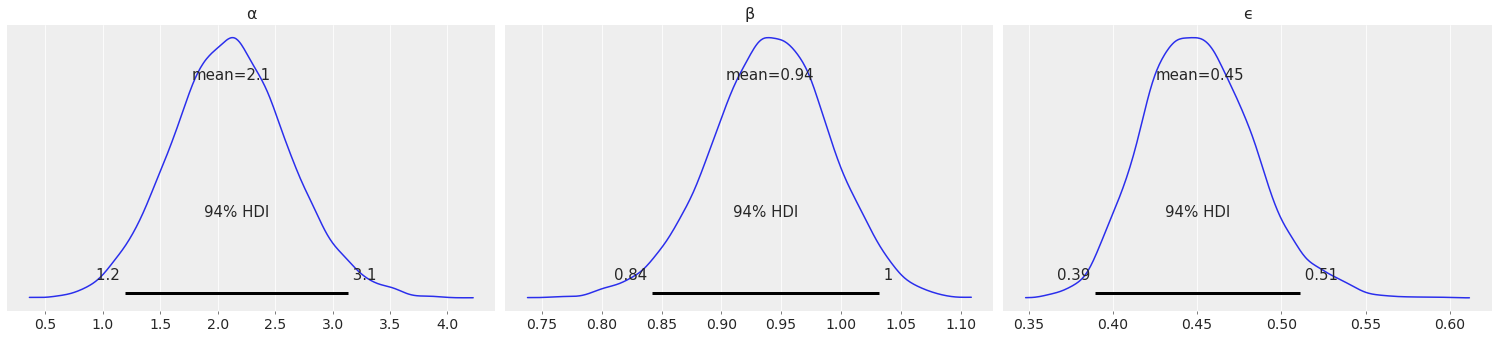

In [135]:
with model_g: 
    az.plot_posterior(trace_g, var_names=['α', 'β', 'ϵ']) # , rope=[0.25, .45], ref_val=0.35)

In [136]:
# with model_g:
#     y_pred2 = pm.Normal('y_pred2', mu= α + β * x, sd=ϵ, observed=y) 

In [142]:
# from sklearn.linear_model import LinearRegression

# linear_regressor = LinearRegression()  # create object for the class
# linear_regressor.fit(x, y)  # perform linear regression
# Y_pred = linear_regressor.predict(x)  # make predictions
# display(Y_pred)

# plt.scatter(x, y)
# plt.plot(x, y_pred, color='red')
# plt.show()

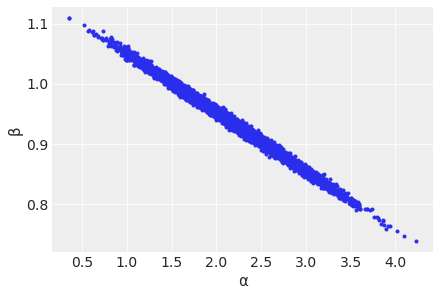

In [146]:
# !pip install scikit-learn

with model_g: 
    az.plot_pair(trace_g, var_names=['α', 'β'])
#     , plot_kwargs={'alpha': 0.8})


Linear models lead to posterior distribution where $\alpha$ and $\beta$ are highly correlated. In this case, all the data should pass for one point, that is, the mean of the $x$ variable and the mean of the $y$ variable. 

A simple way to remove correlation of $\alpha$ and $\beta$ is to center the $x$ variable.
$$x_{i} = x - \bar{x}$$

Compare the results with and without centering the data

Along with centering and transforming, we can standardize the data as well. 

$$x' = \frac{x-\bar{x}}{x_{sd}}$$
$$y' = \frac{y-\bar{y}}{y_{sd}}$$

One advantage of standardizing the data is that we can always use the same weakly informative priors without having to think about the scale of the data. ???




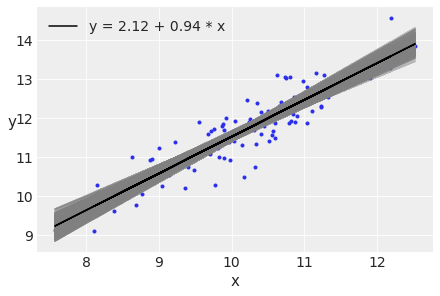

In [148]:
plt.plot(x, y, 'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.show()


/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


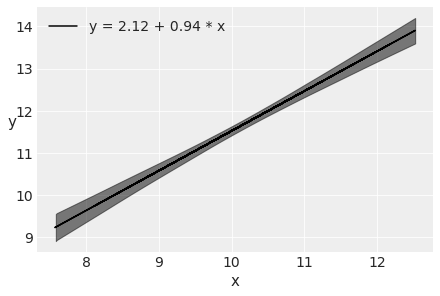

In [156]:
plt.plot(x, alpha_m + beta_m * x, c='k',          
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x') 
sig = az.plot_hdi(x, trace_g['μ'], color='k', hdi_prob=0.98) 
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()
plt.show()

In [154]:
ppc = pm.sample_posterior_predictive(trace_g, samples=2000, model=model_g)


/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


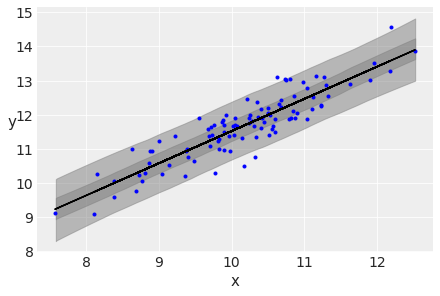

In [162]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc['y_pred'], hdi_prob=0.5, color='gray') # , smooth=False
az.plot_hdi(x, ppc['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

### Pearson correlation coefficient
- says nothing about non-linear correlations

$$r = \beta\frac{\sigma_{x}}{\sigma_{y}}$$ 

- The Pearson correlation coefficient ($r$) is a measure of the degree of correlation between two variables and is always restricted to the interval \[-1, 1\], regardless of the scale of the data.
- The slope of a linear regression ($\sigma$) indicates how much $y$ changes per unit change of $x$, and can take any real value.

In [163]:
az.r2_score(y, ppc['y_pred']) # R-squared

r2        0.708818
r2_std    0.034599
dtype: float64

### Pearson coefficient for multivariate Gaussian

$$ \Sigma =
  \begin{bmatrix}
    \sigma_{x_{1}}^{2} & \rho\sigma_{x_{1}}\sigma_{x_{2}} \\
    \rho\sigma_{x_{1}}\sigma_{x_{2}} & \sigma_{x_{2}}^{2}
  \end{bmatrix}
$$


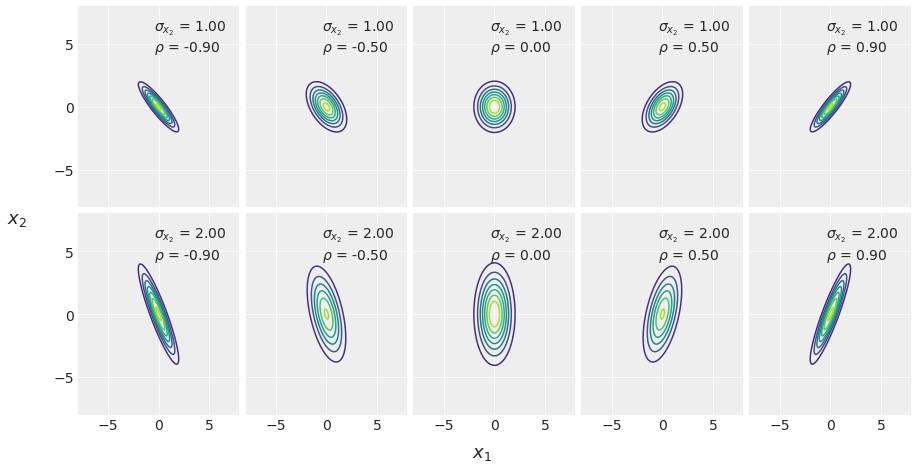

In [167]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k
pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i, j].contour(k, l, rv.pdf(pos))
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0,
                      label=f'$\\sigma_{{x_2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, '$x_{1}$', ha='center', fontsize=18)
f.text(-0.05, 0.5, '$x_2$', va='center', fontsize=18, rotation=0)
plt.show()

- As covariance matrix is unknown, the priors needs to be used. 
- Wishart distribution is the conjugate prior of inverse covariance matrix of a multivariate normal

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3064566383.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_p = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ρ, σ_2, σ_1, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


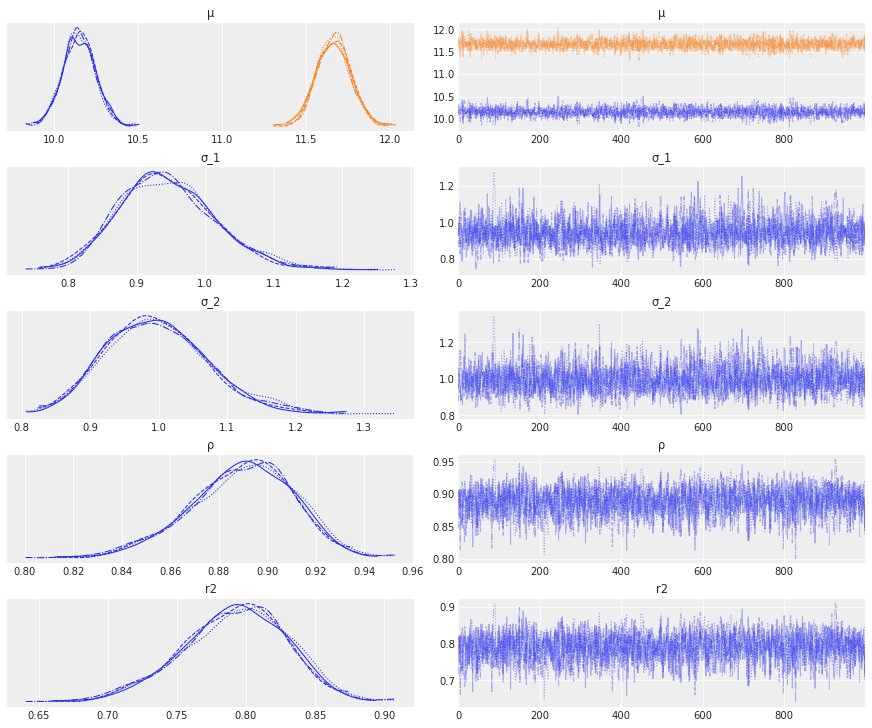

In [168]:
data = np.stack((x, y)).T
with pm.Model() as pearson_model:

    μ = pm.Normal('μ', mu=data.mean(0), sd=10, shape=2)

    σ_1 = pm.HalfNormal('σ_1', 10)
    σ_2 = pm.HalfNormal('σ_2', 10)
    ρ = pm.Uniform('ρ', -1., 1.)
    r2 = pm.Deterministic('r2', ρ**2)

    cov = pm.math.stack(([σ_1**2, σ_1*σ_2*ρ],
                         [σ_1*σ_2*ρ, σ_2**2]))

    y_pred = pm.MvNormal('y_pred', mu=μ, cov=cov, observed=data)

    trace_p = pm.sample(1000)

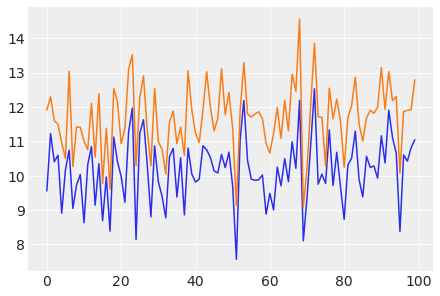

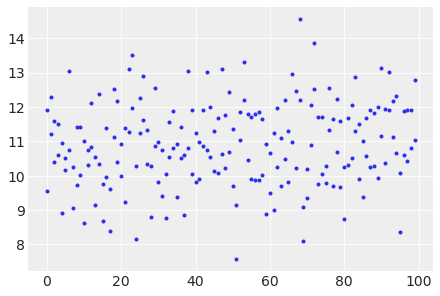

In [176]:
plt.plot(data)
plt.show()
plt.plot(data, 'C0.');

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
r2  0.791  0.038   0.717    0.858      0.001    0.001    2018.0    1860.0   

    r_hat  
r2    1.0

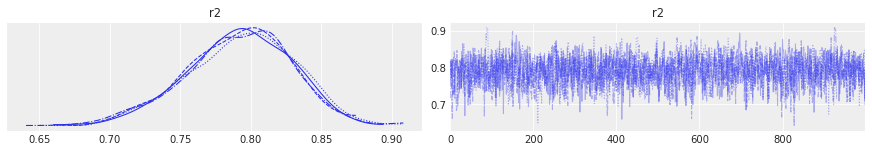

In [169]:
with pearson_model:
    az.plot_trace(trace_p, var_names=['r2']) 
    display(az.summary(trace_p, var_names=['r2']))

### Applying Anscombe's Quartet
- check robustness of Student's T-distribution to a linear regression model using third data group from Anscombe's Quartet

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Anscombe%27s_quartet_3.svg/850px-Anscombe%27s_quartet_3.svg.png">

In [178]:
ans = pd.read_csv('./data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

In [181]:
display(ans.iloc[np.r_[0:4, -4:0]]) # display head and tail 4 elements

group     x      y
0      I  10.0   8.04
1      I   8.0   6.95
2      I  13.0   7.58
3      I   9.0   8.81
40    IV  19.0  12.50
41    IV   8.0   5.56
42    IV   8.0   7.91
43    IV   8.0   6.89

In [185]:
# help(np.r_)
# np.r_[0:4, -4:0]
# TODO: Add it over to data_analysis notebook

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/1808679370.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


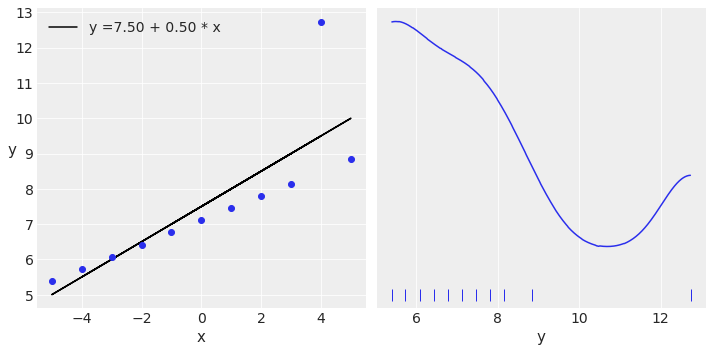

In [186]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()
plt.show()

In [189]:
# help(az.plot_kde)
# Generate Kernel Density Estimate plot using Gaussian kernels.

# In statistics, kernel density estimation (KDE) is a 
# non-parametric way to estimate the probability density 
# function (PDF) of a random variable. This function uses 
# Gaussian kernels and includes automatic bandwidth determination.


In [190]:
with pm.Model() as model_t:
    α = pm.Normal('α', mu=y_3.mean(), sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfNormal('ϵ', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                         sd=ϵ, nu=ν, observed=y_3)

    trace_t = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/2115377906.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_t = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/989740972.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


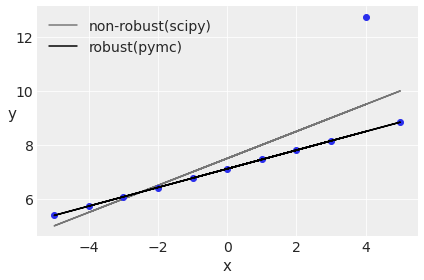

In [192]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust(scipy)', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['α'].mean()
beta_m = trace_t['β'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust(pymc)')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()
plt.show()

- The non-robust fit tries to compromise and include all points
- the robust Bayesian model, model_t, automatically discards one point and fits a line that passes exactly through all the remaining points. 
- A Student's t-distribution gives less importance to outliers due to its heavier tails

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


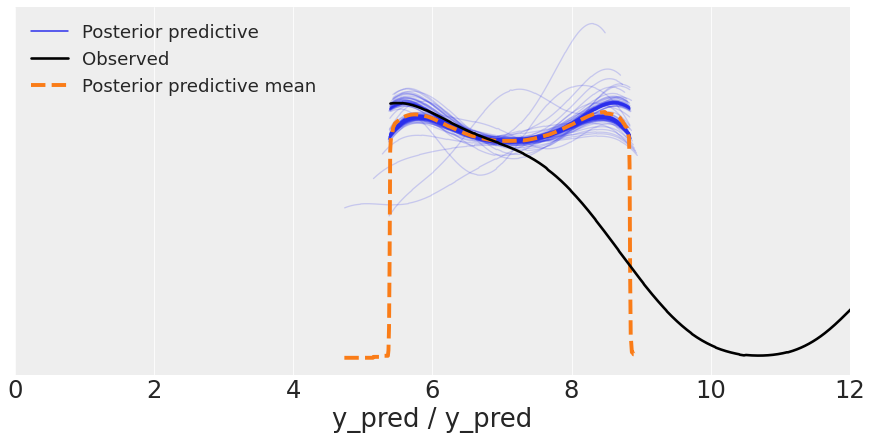

In [193]:
with model_t:
    ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t, random_seed=2)

    data_ppc = az.from_pymc3(trace=trace_t, posterior_predictive=ppc)
    ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
    plt.xlim(0, 12)

## Hierarchical linear regression
- such model deals with inferences at group and subgroup level using hyperpriors
- this **allows information to be shared between groups**
- this is useful in sparse datasets
- below is the **use case of a group with single data point**

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3180591565.py:27: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


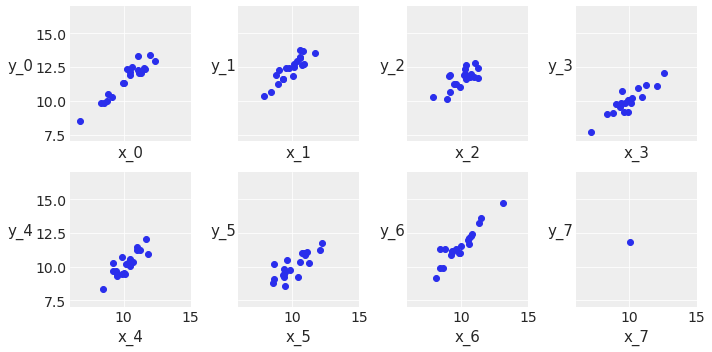

In [194]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)

    j += N
    k += N
plt.tight_layout()
plt.show()

In [195]:
# center the data
x_centered = x_m - x_m.mean()

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3293862030.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_up = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


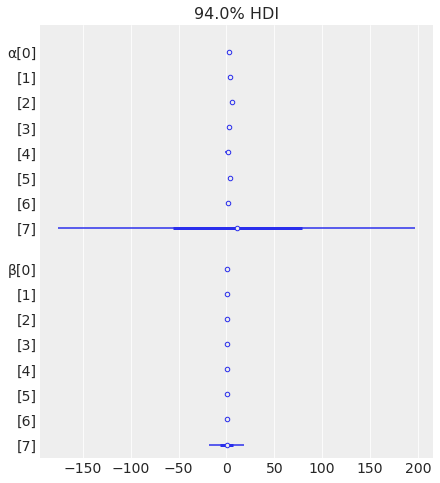

In [196]:
with unpooled_model:
    az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)

## Hierarchical linear regression with hyperpriors

<img src='./images/kruschke_dia_hierarchical_lin_reg.png'>

- add hyperpriors
- add centered scale (diff with mean)

In [198]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    
###     This is how y_m(observed data) was derived
#     N = 20
#     M = 8
#     idx = np.repeat(range(M-1), N)
#     idx = np.append(idx, 7)
#     np.random.seed(314)

#     alpha_real = np.random.normal(2.5, 0.5, size=M)
#     beta_real = np.random.beta(6, 1, size=M)
#     eps_real = np.random.normal(0, 0.5, size=len(idx))

#     y_m = np.zeros(len(idx))
#     x_m = np.random.normal(10, 1, len(idx))
#     y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

    y_pred = pm.StudentT('y_pred',
                         mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/2822513498.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_hm = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6795601126151234, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


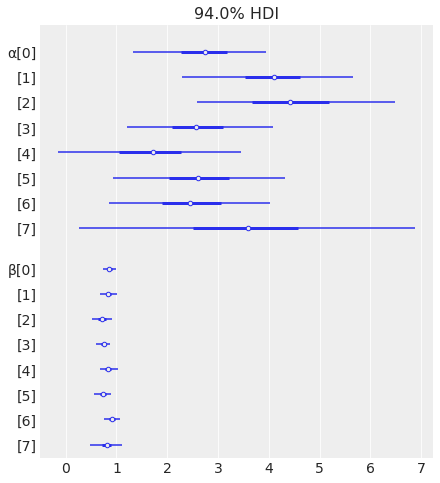

In [199]:
with hierarchical_model:
    az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)

A better way to compare models would be to show both the models
- unpooled_model
- hierarchical_model

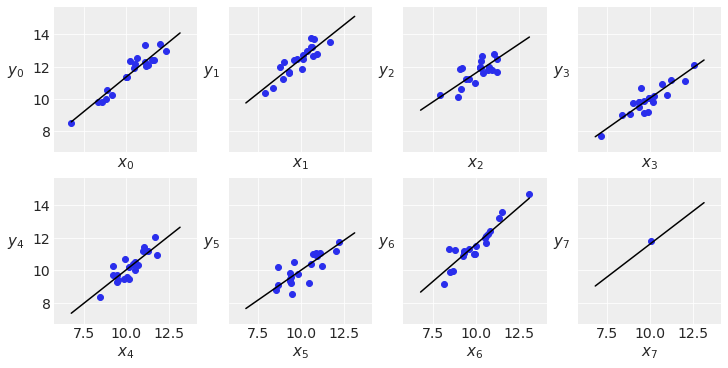

In [201]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'$x_{i}$')
    ax[i].set_ylabel(f'$y_{i}$', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.show()

- each fitted line is informed by the fitted lines of the other groups
- the last group also inferred from other groups thereby adjusting to the group rather to a single point

### Causation
- Correlation does not imply causation

## Polynomial regression
$$\mu = \beta_{0} + \beta_{1}x^1 + \beta_{2}x^2$$

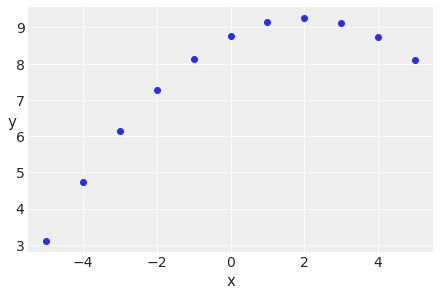

In [204]:
# Anscombe quartet - 2nd group
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

In [205]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)

    trace_poly = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3041701010.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_poly = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


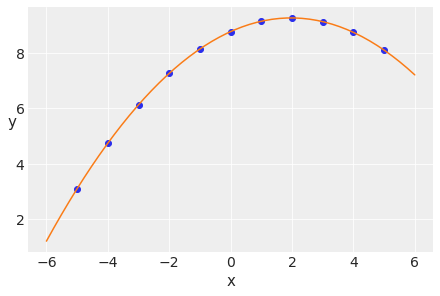

In [209]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * \
    x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1');


## Multiple linear regression
- **Multiple regression** (aka multivariable regression) pertains to one dependent variable and multiple independent variables: $𝑦=𝑓(𝑥_1,𝑥_2,...,𝑥_n)$
$$\mu = \alpha + X\beta$$
$$\mu = \alpha + \sum\limits_{i=1}^{n}\beta_{i}x_{i}$$
$$\mu = \alpha + \beta_{1}x_{1} + \beta_{2}x_{2} + ... + \beta_{m}x_{m} $$
  - n is the number of observations
  - m is the number of independent variables


- **Multivariate regression** pertains to multiple dependent variables and multiple independent variables: $𝑦_1,𝑦_2,...,𝑦_𝑚=𝑓(𝑥_1,𝑥_2,...,𝑥_𝑛)$. You may encounter problems where both the dependent and independent variables are arranged as matrices of variables (e.g. $𝑦_{11},𝑦_{12},... \text{ and }𝑥_{11},𝑥_{12},...)$, so the expression may be written as $𝑌=𝑓(𝑋)$, where capital letters indicate matrices.

- **Bayesian form of Multiple regression** - find a hyperplane of m dimension 

In [210]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [228]:
def scatter_plot(x, y):
    plt.figure(figsize=(12, 4))
    for idx, x_i in enumerate(x.T):
        plt.subplot(1, 3, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'$x_{idx+1}$')
        plt.ylabel(f'$y$', rotation=0)

    plt.subplot(1, 3, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'$x_{idx}$')
    plt.ylabel(f'$x_{idx+1}$', rotation=0)

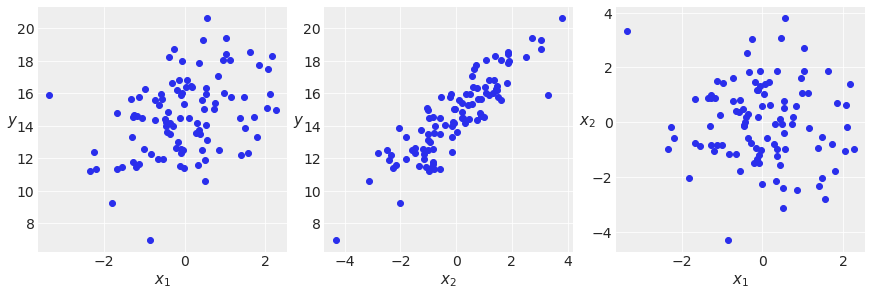

In [229]:
# two between each independent and dependent variable, 
# and the last one between both dependent variables
scatter_plot(X_centered, y) 

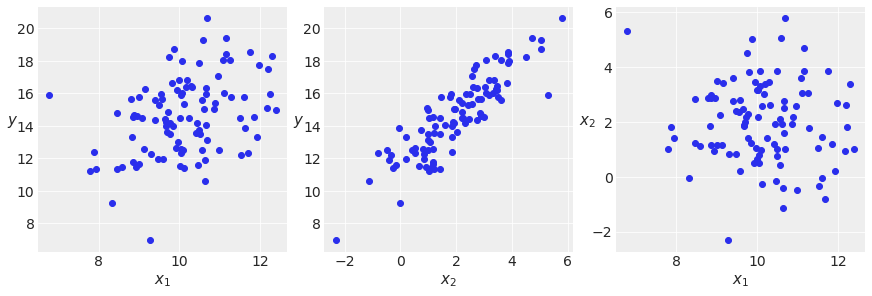

In [230]:
scatter_plot(X, y) 

In [231]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/581377289.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_mlr = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α_tmp]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


In [234]:
with model_mlr:
    varnames = ['α', 'β', 'ϵ']
    display(az.summary(trace_mlr, var_names=varnames))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α[0]  1.847  0.458   0.965    2.697      0.004    0.003   11142.0    5773.0   
β[0]  0.969  0.044   0.887    1.054      0.000    0.000   11233.0    5512.0   
β[1]  1.470  0.033   1.408    1.530      0.000    0.000   11562.0    6394.0   
ϵ     0.474  0.035   0.410    0.540      0.000    0.000   10523.0    5876.0   

      r_hat  
α[0]    1.0  
β[0]    1.0  
β[1]    1.0  
ϵ       1.0

## Confounding variables
- Not taking into account confounding variables in an analysis could lead us to spurious correlation
- for example, omitting variable z(confounding) from analysis and only including variable x and y

In [242]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N) # confounding variable
x_2 = x_1 + np.random.normal(size=N, scale=1)
# x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

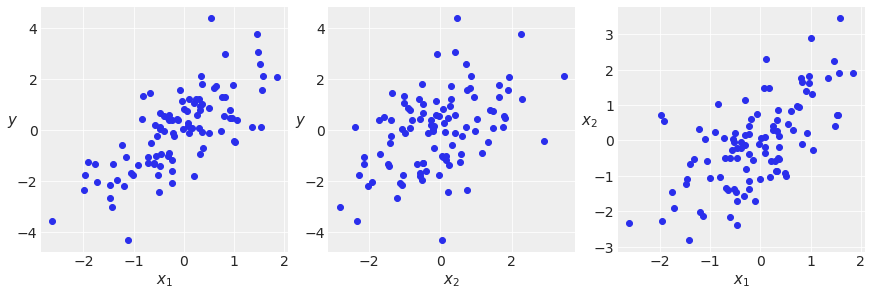

In [243]:
scatter_plot(X, y)

In [244]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/119509338.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/119509338.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/119509338.py:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


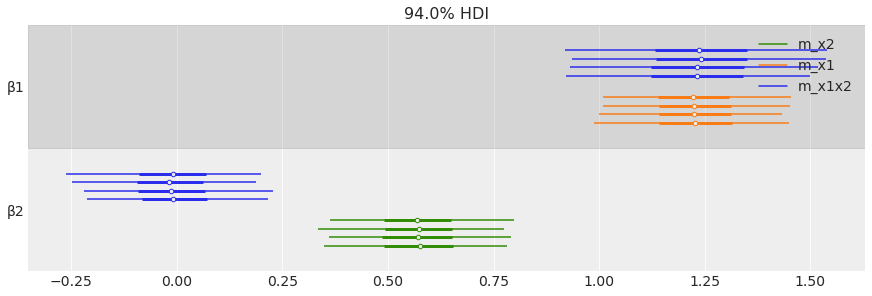

In [247]:
with m_x1x2, m_x1, m_x2:
#     az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)
    az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(12, 4))

In [248]:
with m_x1x2, m_x1, m_x2:
    display(az.summary(trace_x1x2))
    display(az.summary(trace_x1))
    display(az.summary(trace_x2))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.090  0.111  -0.117    0.299      0.001    0.001    8163.0    5667.0   
β1  1.237  0.160   0.934    1.535      0.002    0.002    4834.0    5457.0   
β2 -0.012  0.118  -0.219    0.227      0.002    0.001    4604.0    5370.0   
ϵ   1.088  0.079   0.947    1.239      0.001    0.001    6999.0    5385.0   

    r_hat  
α     1.0  
β1    1.0  
β2    1.0  
ϵ     1.0

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.090  0.110  -0.119    0.295      0.001    0.001   10275.0    5730.0   
β1  1.226  0.122   1.007    1.457      0.001    0.001   10436.0    5566.0   
ϵ   1.083  0.080   0.935    1.228      0.001    0.001    9852.0    5976.0   

    r_hat  
α     1.0  
β1    1.0  
ϵ     1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.006  0.143  -0.280    0.263      0.001    0.002   10550.0    5709.0   
β2  0.571  0.118   0.360    0.797      0.001    0.001    9308.0    5605.0   
ϵ   1.399  0.101   1.222    1.593      0.001    0.001   10215.0    6333.0   

    r_hat  
α     1.0  
β2    1.0  
ϵ     1.0

- model m_x1x2:
  - linear regression with 2 independent variables x1, x2
- model m_x1:
  - linear regression with 1 independent variables x1
- model m_x2:
  - linear regression with 1 independent variables x2


- Slope component $\beta_{2}$
  - model m_x1x2:
    - it is around 0, indicating no contribution of $x_2$ variable to explain y
    - the power of $x_2$ to predict y reduces when $x_1$ is taken into account
      - $x_2$ is redundant
  - model m_x2:
    - it is around 0.57, indicating no contribution of $x_2$ variable to explain y

## Multicollinearity 
- increase degree of correlation between $x_1$ and $x_2$ by reducing the amount of Gaussian noise we add to $x_1$ to obtain $x_2$
- this is done by using lower value of scale parameter

In [249]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

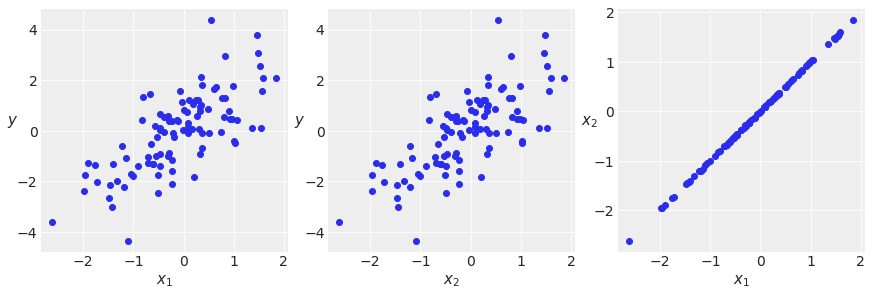

In [250]:
scatter_plot(X, y)

In [251]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_red = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/2066427073.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_red = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 66 seconds.
There were 167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8803200220765189, but should be close to 0.8. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


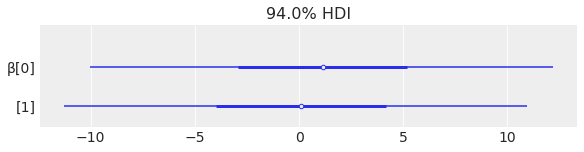

In [252]:
with model_red:
    az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8, 
               2))

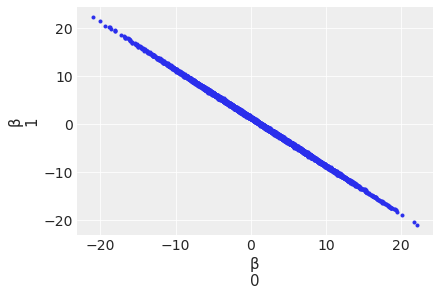

In [253]:
with model_red:
    az.plot_pair(trace_red, var_names=['β'])

- the plot shows the marginal posterior $\beta$ is highly correlated
- the relationship is more or less instead of 
$$\mu = \alpha + \beta_1x_1 + \beta_2x_2$$
- is
$$\mu = \alpha + (\beta_1 + \beta_2)x$$
- What to do?
  - Eliminate one of the variables 
  - create new variable averaging the redundant variable
    - using Principal Component Analysis (PCA)
  - use stronger priors restricting coeff values - Chap6

## Masking effect variables
- $x_1$ and $x_2$ are positively correlated
- ($x_1$ and y) are positively correlated
- ($x_2$ and y) are negatively correlated

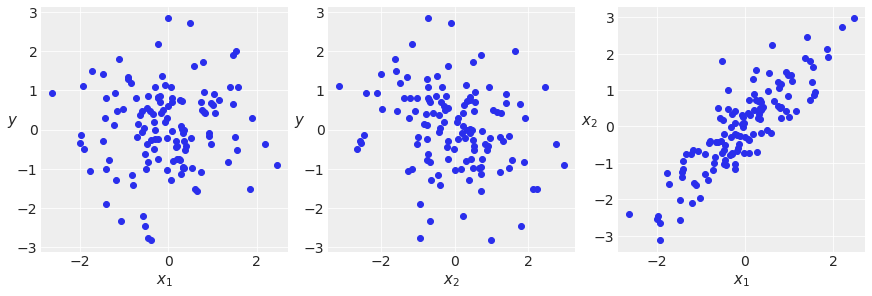

In [254]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T
scatter_plot(X, y)

In [268]:
# np.corrcoef()
# np.vstack((X, y.T))

In [255]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/119509338.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8891382339438687, but should be close to 0.8. Try to increase the number of tuning steps.
/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/119509338.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x1 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β1, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/119509338.py:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_x2 = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β2, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

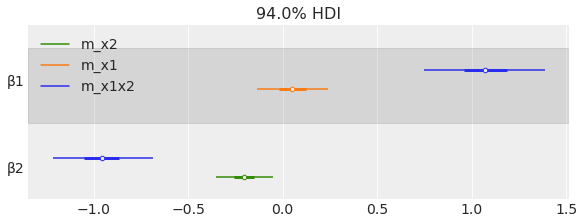

In [256]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))

In [257]:
with m_x1x2, m_x1, m_x2:
    display(az.summary(trace_x1x2))
    display(az.summary(trace_x1))
    display(az.summary(trace_x2))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.076  0.082  -0.077    0.233      0.001    0.001    6911.0    4933.0   
β1  1.072  0.172   0.748    1.387      0.002    0.002    4729.0    4660.0   
β2 -0.956  0.140  -1.215   -0.686      0.002    0.001    4719.0    4318.0   
ϵ   0.912  0.059   0.808    1.026      0.001    0.001    6498.0    5218.0   

    r_hat  
α     1.0  
β1    1.0  
β2    1.0  
ϵ     1.0

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.050  0.099  -0.148    0.224      0.001    0.001    9802.0    5789.0   
β1  0.053  0.102  -0.138    0.238      0.001    0.001   11160.0    5931.0   
ϵ   1.072  0.071   0.945    1.205      0.001    0.001    9282.0    5330.0   

    r_hat  
α     1.0  
β1    1.0  
ϵ     1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α   0.038  0.093  -0.133    0.213      0.001    0.001   10662.0    5990.0   
β2 -0.204  0.080  -0.354   -0.053      0.001    0.001   10978.0    5518.0   
ϵ   1.045  0.069   0.919    1.173      0.001    0.000   10390.0    5128.0   

    r_hat  
α     1.0  
β2    1.0  
ϵ     1.0

- values of $\beta$ for m_x1x2 are close to -1 and 1
- $x_1$ is correlated to $x_2$. 
- when $x_1$ increases, $x_2$ also increases. 
- when y increases $x_1$ also increases, but $x_2$ decreases. 
- partial cancellation effects unless both variables are included


## Interactions

$$\mu = \alpha + \beta_1x_1 + \beta_2x_2 + \beta_3x_1x_2$$
$$\mu = \alpha + (\beta_1 + \beta_3x_2)x_1 + \beta_2x_2$$
$$\mu = \alpha + \beta_1x_1 + (\beta_2 + \beta_3x_1)x_2$$


- it is a linear model with a linear model inside of it
- interaction is symmetric, slope of $x_1$ is a function of $x_2$, and slope of $x_2$ is a function of $x_1$

## TODO-MOVE - Alogorithm - Spiral

In [290]:
def spiral(X, Y):
    x = y = 0
    dx = 0
    dy = -1
    for i in range(max(X, Y)**2):
        if (-X/2 < x <= X/2) and (-Y/2 < y <= Y/2):
            print (x, y)
            # DO STUFF...
        if x == y or (x < 0 and x == -y) or (x > 0 and x == 1-y):
            dx, dy = -dy, dx
        x, y = x+dx, y+dy
        

In [291]:
spiral(3,3)

0 0
1 0
1 1
0 1
-1 1
-1 0
-1 -1
0 -1
1 -1


In [292]:
X = 3, Y = 3
x = 0, y = 0

9 iterations

1 iteration
(-1.5 < x <= 1.5) and (-1.5 < y <= 1.5) 
    print(0,0)
x == y
    dx = 1
    dy = 0
x,y = 1,0

2 iteration
(-1.5 < x <= 1.5) and (-1.5 < y <= 1.5) 
    print(1,0)
(x > 0 and x == 1-y)
    dx, dy = -0, 1
x,y = 1, 1

1.5

## Model Comparison
### Posterior predictive checks

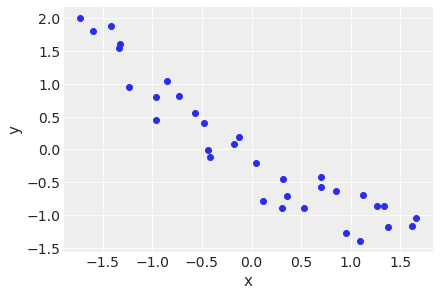

In [294]:
dummy_data = np.loadtxt('./data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
    x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y');

In [303]:
# Fit in two ways
# - Linear model
# - Quadratic model
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_l = pm.sample(2000)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_p = pm.sample(2000)

/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3021731110.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_l = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
/var/folders/kz/g_s979xs7pdbzdsbg21qhs240000gn/T/ipykernel_21912/3021731110.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_p = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


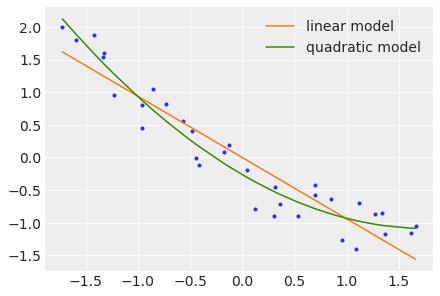

In [306]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'quadratic model')

α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend();

In [307]:
# Posterior Predictor samples
with model_l:
    y_l = pm.sample_posterior_predictive(trace_l, 2000,
                                     model=model_l)['y_pred']

with model_p:
    y_p = pm.sample_posterior_predictive(trace_p, 2000,
                                     model=model_p)['y_pred']

/Users/chandrasingh/opt/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


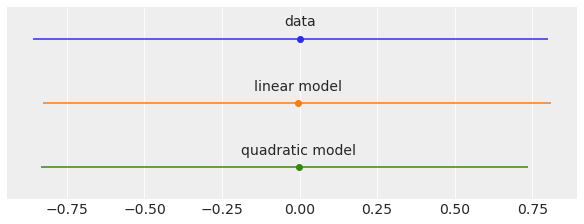

In [310]:
# Interquartile range (IQR)

plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'quadratic model']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

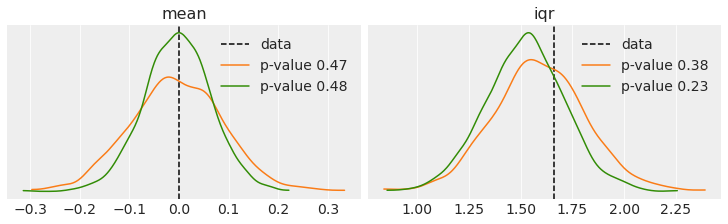

In [312]:
# p-value - indicates the fit of a posterior predictive check
#    If the data and simulation agrees, we should expect a 
#    p-value around 0.5, otherwise we are in the presence 
#    of a biased posterior predictive distribution

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)


def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--', label='data')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()
plt.show()

$$\text{Bayesian p-value} \triangleq p(T_{sim} \ge T_{obs} | y)$$

### Information Criteria
- mechanism of using different tools to learn about models
  - to compare models
  - how fit the data is
  - how complex the model is
- this comes from field of information theory


- square the error
- log likelihood
  - when likelihood is normal, will be proportional to quadratic mean error
$$\sum\limits_{i=1}^{n}\log p(y_{i}|\theta)$$
- deviance  
$$-2\sum\limits_{i=1}^{n}\log p(y_{i}|\theta)$$
- lower the deviance, higher is the log-likelihood, higher is the model prediction agreement
- complex models will have lower deviance, so use penalization factor
- AIC (Akaike information criteria)
$$AIC = -2\sum\limits_{i=1}^{n}\log p(y_{i}|\hat{\theta}_{mle}) + 2p_{AIC}$$
- WAIC (Widely applicable Information criteria)
$$WAIC = -2lppd + 2p_{WAIC}$$
  - first term - how well the data fits the model
  - second term - penalizing complex model
- LOO-CV (Pareto smoothed importance sampling leave-one-out cross validation) 
- BIC (Bayesian Information Criterion)
- DIC (Deviance Information Criterion)
- BMA (Bayesian Model Averaging)
- KL divergence (Kullback-Leibler divergence)

In [317]:
with model_l:
    display(az.waic(trace_l))
    display(az.loo(trace_l))

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -14.33     2.67
p_waic        2.42        -

Computed from 8000 posterior samples and 33 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -14.35     2.67
p_loo        2.44        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       33  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### References
